# Cell 1: Setup & Import

In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import RegulatedPurePursuitController
from path_trajectory_pkg.trajectory_rpp_controller import RegulatedPurePursuitController

print("✓ Imports successful")
print("✓ RegulatedPurePursuitController loaded\n")


✓ Imports successful
✓ RegulatedPurePursuitController loaded



# Cell 2: Create Test Trajectory and Robot States

In [21]:
# Create a curved trajectory with curvature data
n_points = 50
theta = np.linspace(0, 2*np.pi, n_points)
radius = 5.0

# Create trajectory with curvature information
test_trajectory = {
    'x': radius * np.cos(theta),
    'y': radius * np.sin(theta),
    'time': np.linspace(0, 20, n_points),
    'velocity': np.ones(n_points) * 0.5,  # Constant 0.5 m/s
    'curvature': np.ones(n_points) * (1.0 / radius)  # Constant curvature for circle
}

# Create test robot poses
test_robot_poses = {
    'start': (radius, 0.0, np.pi/2),
    'on_path': (radius * np.cos(np.pi/4), radius * np.sin(np.pi/4), 3*np.pi/4),
    'near_sharp_curve': (2.0, 2.0, np.pi),  # High curvature area
    'near_goal': (radius * np.cos(1.9*np.pi), radius * np.sin(1.9*np.pi), 0.0),
    'far_from_goal': (radius * np.cos(0.1*np.pi), radius * np.sin(0.1*np.pi), np.pi/2)
}

# Controller parameters
lookahead_time = 1.5
min_lookahead = 0.3
max_lookahead = 1.5
desired_linear_vel = 0.8
min_approach_vel = 0.25
approach_vel_scaling_dist = 0.6
min_radius_for_regulation = 0.5
min_regulated_speed = 0.15
goal_tolerance = 0.15

print("✓ Test trajectory created")
print(f"  - Trajectory: {len(test_trajectory['x'])} points")
print(f"  - Path shape: Circular (radius={radius} m)")
print(f"  - Curvature: {test_trajectory['curvature'][0]:.4f} m⁻¹")
print(f"  - Test robot poses: {len(test_robot_poses)} scenarios\n")


✓ Test trajectory created
  - Trajectory: 50 points
  - Path shape: Circular (radius=5.0 m)
  - Curvature: 0.2000 m⁻¹
  - Test robot poses: 5 scenarios



# Cell 3A: Test Lookahead and Navigation Functions

In [23]:
print("="*60)
print("TESTING LOOKAHEAD & NAVIGATION")
print("="*60)

# Test 1: compute_adaptive_lookahead_distance()
print("\n[Test 1] compute_adaptive_lookahead_distance()")
print("-" * 60)

def compute_adaptive_lookahead_distance(robot_velocity, lookahead_time, 
                                        min_lookahead, max_lookahead):
    """Compute time-based adaptive lookahead."""
    L = lookahead_time * max(robot_velocity, 0.1)
    L = np.clip(L, min_lookahead, max_lookahead)
    return L

print(f"Purpose: Time-based lookahead (L = lookahead_time * v)")
print(f"Parameters: time={lookahead_time}s, min={min_lookahead}m, max={max_lookahead}m")
print("\nResults:")

test_velocities = [0.0, 0.2, 0.5, 1.0, 2.0]
for v in test_velocities:
    L = compute_adaptive_lookahead_distance(v, lookahead_time, min_lookahead, max_lookahead)
    print(f"  • v={v:.1f} m/s → L={L:.3f} m")

# Verify clamping
L_max_test = compute_adaptive_lookahead_distance(10.0, lookahead_time, min_lookahead, max_lookahead)
if L_max_test == max_lookahead:
    print(f"✅ PASS: Maximum lookahead clamping works")
else:
    print(f"❌ FAIL: Maximum clamping not working")

# Test 2: find_closest_point()
print("\n[Test 2] find_closest_point()")
print("-" * 60)

def find_closest_point(robot_pose, trajectory):
    """Find closest point on trajectory."""
    x_robot, y_robot, _ = robot_pose
    dx = trajectory['x'] - x_robot
    dy = trajectory['y'] - y_robot
    distances = np.sqrt(dx**2 + dy**2)
    return int(np.argmin(distances)), distances[np.argmin(distances)]

print("Purpose: Find nearest waypoint to robot")
print("Results:")

for name, pose in list(test_robot_poses.items())[:3]:
    idx, dist = find_closest_point(pose, test_trajectory)
    print(f"  • {name:20s}: idx={idx:2d}, distance={dist:.3f} m")

# Verify on-path point
idx, dist = find_closest_point(test_robot_poses['on_path'], test_trajectory)
if dist < 0.5:
    print(f"✅ PASS: On-path robot correctly identified")
else:
    print(f"❌ FAIL: On-path distance too large ({dist:.3f} m)")

# Test 3: compute_lookahead_point()
print("\n[Test 3] compute_lookahead_point()")
print("-" * 60)

def compute_lookahead_point(robot_pose, start_idx, lookahead_dist, trajectory):
    """Compute lookahead point on trajectory."""
    x_robot, y_robot, _ = robot_pose
    
    for i in range(start_idx, len(trajectory['x'])):
        dx = trajectory['x'][i] - x_robot
        dy = trajectory['y'][i] - y_robot
        distance = np.sqrt(dx**2 + dy**2)
        
        if distance >= lookahead_dist:
            return i, (trajectory['x'][i], trajectory['y'][i])
    
    last_idx = len(trajectory['x']) - 1
    return last_idx, (trajectory['x'][last_idx], trajectory['y'][last_idx])

print("Purpose: Find lookahead point ahead of robot")
print("Results:")

robot_pose = test_robot_poses['on_path']
closest_idx, _ = find_closest_point(robot_pose, test_trajectory)

for v in [0.2, 0.5, 1.0]:
    L = compute_adaptive_lookahead_distance(v, lookahead_time, min_lookahead, max_lookahead)
    idx, point = compute_lookahead_point(robot_pose, closest_idx, L, test_trajectory)
    print(f"  • v={v:.1f} m/s: L={L:.3f} m → lookahead_idx={idx}")

print("\n" + "="*60)
print("LOOKAHEAD & NAVIGATION TESTS COMPLETE")
print("="*60 + "\n")


TESTING LOOKAHEAD & NAVIGATION

[Test 1] compute_adaptive_lookahead_distance()
------------------------------------------------------------
Purpose: Time-based lookahead (L = lookahead_time * v)
Parameters: time=1.5s, min=0.3m, max=1.5m

Results:
  • v=0.0 m/s → L=0.300 m
  • v=0.2 m/s → L=0.300 m
  • v=0.5 m/s → L=0.750 m
  • v=1.0 m/s → L=1.500 m
  • v=2.0 m/s → L=1.500 m
✅ PASS: Maximum lookahead clamping works

[Test 2] find_closest_point()
------------------------------------------------------------
Purpose: Find nearest waypoint to robot
Results:
  • start               : idx= 0, distance=0.000 m
  • on_path             : idx= 6, distance=0.080 m
  • near_sharp_curve    : idx= 6, distance=2.172 m
✅ PASS: On-path robot correctly identified

[Test 3] compute_lookahead_point()
------------------------------------------------------------
Purpose: Find lookahead point ahead of robot
Results:
  • v=0.2 m/s: L=0.300 m → lookahead_idx=7
  • v=0.5 m/s: L=0.750 m → lookahead_idx=8
  • v=1.

# Cell 3B: Test Velocity Regulation Functions

In [24]:
print("="*60)
print("TESTING VELOCITY REGULATION (RPP KEY FEATURE)")
print("="*60)

# Test 4: Curvature-based velocity regulation
print("\n[Test 4] Curvature-Based Velocity Scaling")
print("-" * 60)

def regulate_velocity_curvature(v_desired, curvature, use_scaling,
                                 min_radius_for_regulation, min_regulated_speed):
    """Apply curvature-based velocity regulation."""
    v_regulated = v_desired
    
    if use_scaling and curvature > 1e-6:
        radius = 1.0 / curvature
        
        if radius < min_radius_for_regulation:
            scaling_factor = radius / min_radius_for_regulation
            v_regulated = v_regulated * scaling_factor
            v_regulated = max(v_regulated, min_regulated_speed)
    
    return v_regulated

print(f"Purpose: Slow down on sharp curves")
print(f"Formula: If radius < threshold, v' = v * (radius/threshold)")
print(f"Parameters: min_radius={min_radius_for_regulation}m, min_speed={min_regulated_speed}m/s")
print("\nResults:")

test_curvatures = [0.0, 0.5, 1.0, 2.0, 5.0]  # m⁻¹
v_desired = 0.8

for curv in test_curvatures:
    radius = 1.0/curv if curv > 0 else float('inf')
    v_reg = regulate_velocity_curvature(v_desired, curv, True,
                                         min_radius_for_regulation, min_regulated_speed)
    print(f"  • κ={curv:.1f} m⁻¹ (r={radius:.2f}m) → v={v_reg:.3f} m/s")

# Verify high curvature slows down
v_high_curv = regulate_velocity_curvature(0.8, 5.0, True, min_radius_for_regulation, min_regulated_speed)
if v_high_curv < 0.8:
    print(f"✅ PASS: High curvature reduces velocity")
else:
    print(f"❌ FAIL: High curvature regulation not working")

# Test 5: Goal approach velocity scaling
print("\n[Test 5] Goal Approach Velocity Scaling")
print("-" * 60)

def regulate_velocity_goal_approach(v_regulated, distance_to_goal,
                                     desired_linear_vel, min_approach_vel,
                                     approach_vel_scaling_dist):
    """Apply goal approach velocity regulation."""
    if distance_to_goal < approach_vel_scaling_dist:
        scaling_factor = distance_to_goal / approach_vel_scaling_dist
        v_approach = desired_linear_vel * scaling_factor
        v_approach = max(v_approach, min_approach_vel)
        v_regulated = min(v_regulated, v_approach)
    
    return v_regulated

print(f"Purpose: Slow down when approaching goal")
print(f"Formula: If dist < threshold, v' = v_max * (dist/threshold)")
print(f"Parameters: scaling_dist={approach_vel_scaling_dist}m, min_vel={min_approach_vel}m/s")
print("\nResults:")

test_distances = [2.0, 1.0, 0.6, 0.3, 0.1]  # meters to goal

for dist in test_distances:
    v_reg = regulate_velocity_goal_approach(0.8, dist, desired_linear_vel,
                                             min_approach_vel, approach_vel_scaling_dist)
    print(f"  • Distance to goal={dist:.1f} m → v={v_reg:.3f} m/s")

# Verify slowing near goal
v_near_goal = regulate_velocity_goal_approach(0.8, 0.1, desired_linear_vel,
                                               min_approach_vel, approach_vel_scaling_dist)
if v_near_goal < 0.8:
    print(f"✅ PASS: Near goal reduces velocity")
else:
    print(f"❌ FAIL: Goal approach regulation not working")

# Test 6: compute_distance_to_goal()
print("\n[Test 6] compute_distance_to_goal()")
print("-" * 60)

def compute_distance_to_goal(robot_pose, trajectory, current_idx):
    """Compute remaining distance to goal along trajectory."""
    x_robot, y_robot, _ = robot_pose
    
    remaining_distance = 0.0
    for i in range(current_idx, len(trajectory['x']) - 1):
        dx = trajectory['x'][i + 1] - trajectory['x'][i]
        dy = trajectory['y'][i + 1] - trajectory['y'][i]
        remaining_distance += np.sqrt(dx**2 + dy**2)
    
    dx_to_path = trajectory['x'][current_idx] - x_robot
    dy_to_path = trajectory['y'][current_idx] - y_robot
    remaining_distance += np.sqrt(dx_to_path**2 + dy_to_path**2)
    
    return remaining_distance

print("Purpose: Calculate remaining path length to goal")
print("Results:")

for name, pose in [('near_goal', test_robot_poses['near_goal']),
                   ('far_from_goal', test_robot_poses['far_from_goal'])]:
    idx, _ = find_closest_point(pose, test_trajectory)
    dist = compute_distance_to_goal(pose, test_trajectory, idx)
    print(f"  • {name:20s}: {dist:.3f} m remaining")

# Verify near goal has smaller distance
dist_near = compute_distance_to_goal(test_robot_poses['near_goal'], 
                                      test_trajectory, 
                                      find_closest_point(test_robot_poses['near_goal'], test_trajectory)[0])
dist_far = compute_distance_to_goal(test_robot_poses['far_from_goal'], 
                                     test_trajectory,
                                     find_closest_point(test_robot_poses['far_from_goal'], test_trajectory)[0])

if dist_near < dist_far:
    print(f"✅ PASS: Distance calculation correct")
else:
    print(f"❌ FAIL: Distance calculation incorrect")

print("\n" + "="*60)
print("VELOCITY REGULATION TESTS COMPLETE")
print("="*60 + "\n")


TESTING VELOCITY REGULATION (RPP KEY FEATURE)

[Test 4] Curvature-Based Velocity Scaling
------------------------------------------------------------
Purpose: Slow down on sharp curves
Formula: If radius < threshold, v' = v * (radius/threshold)
Parameters: min_radius=0.5m, min_speed=0.15m/s

Results:
  • κ=0.0 m⁻¹ (r=infm) → v=0.800 m/s
  • κ=0.5 m⁻¹ (r=2.00m) → v=0.800 m/s
  • κ=1.0 m⁻¹ (r=1.00m) → v=0.800 m/s
  • κ=2.0 m⁻¹ (r=0.50m) → v=0.800 m/s
  • κ=5.0 m⁻¹ (r=0.20m) → v=0.320 m/s
✅ PASS: High curvature reduces velocity

[Test 5] Goal Approach Velocity Scaling
------------------------------------------------------------
Purpose: Slow down when approaching goal
Formula: If dist < threshold, v' = v_max * (dist/threshold)
Parameters: scaling_dist=0.6m, min_vel=0.25m/s

Results:
  • Distance to goal=2.0 m → v=0.800 m/s
  • Distance to goal=1.0 m → v=0.800 m/s
  • Distance to goal=0.6 m → v=0.800 m/s
  • Distance to goal=0.3 m → v=0.400 m/s
  • Distance to goal=0.1 m → v=0.250 m/s
✅ PA

# Cell 3C: Test Control Commands and Error Tracking

In [25]:
print("="*60)
print("TESTING CONTROL & ERROR TRACKING")
print("="*60)

# Test 7: compute_control_commands()
print("\n[Test 7] compute_control_commands()")
print("-" * 60)

def compute_control_commands(robot_pose, lookahead_point, v_regulated, max_angular_vel):
    """Compute Pure Pursuit control with regulated velocity."""
    x_robot, y_robot, theta_robot = robot_pose
    x_goal, y_goal = lookahead_point
    
    dx = x_goal - x_robot
    dy = y_goal - y_robot
    
    dx_robot = np.cos(theta_robot) * dx + np.sin(theta_robot) * dy
    dy_robot = -np.sin(theta_robot) * dx + np.cos(theta_robot) * dy
    
    L = np.sqrt(dx_robot**2 + dy_robot**2)
    
    if L < 1e-3:
        return 0.0, 0.0
    
    curvature = 2.0 * dy_robot / (L ** 2)
    omega = v_regulated * curvature
    omega = np.clip(omega, -max_angular_vel, max_angular_vel)
    
    return v_regulated, omega

print(f"Purpose: Compute velocity commands using regulated velocity")
print(f"Formula: κ = 2*y_robot/L², ω = v_regulated*κ")
print(f"Max angular velocity: {1.5} rad/s")
print("\nResults:")

# Test with different regulated velocities
robot_pose = test_robot_poses['on_path']
closest_idx, _ = find_closest_point(robot_pose, test_trajectory)
L = compute_adaptive_lookahead_distance(0.5, lookahead_time, min_lookahead, max_lookahead)
lookahead_idx, lookahead_point = compute_lookahead_point(robot_pose, closest_idx, L, test_trajectory)

v_unreg = 0.8
v_reg_high = 0.8
v_reg_low = 0.3  # Simulating regulation

v_cmd1, omega1 = compute_control_commands(robot_pose, lookahead_point, v_unreg, 1.5)
v_cmd2, omega2 = compute_control_commands(robot_pose, lookahead_point, v_reg_low, 1.5)

print(f"  • Unregulated (v={v_unreg:.1f}): v_cmd={v_cmd1:.3f}, ω={omega1:.3f} rad/s")
print(f"  • Regulated (v={v_reg_low:.1f}):   v_cmd={v_cmd2:.3f}, ω={omega2:.3f} rad/s")

if abs(omega1) > abs(omega2):
    print(f"✅ PASS: Lower regulated velocity produces lower angular velocity")
else:
    print(f"⚠️  Angular velocities: ω1={omega1:.3f}, ω2={omega2:.3f}")

# Test 8: normalize_angle()
print("\n[Test 8] normalize_angle()")
print("-" * 60)

def normalize_angle(angle):
    """Normalize angle to [-π, π]."""
    while angle > np.pi:
        angle -= 2.0 * np.pi
    while angle < -np.pi:
        angle += 2.0 * np.pi
    return angle

print("Purpose: Normalize angles to [-π, π] range")

test_angles = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, -3*np.pi/2]
all_normalized = [normalize_angle(a) for a in test_angles]

if all(-np.pi <= a <= np.pi for a in all_normalized):
    print(f"✅ PASS: All angles normalized correctly")
else:
    print(f"❌ FAIL: Some angles outside range")

# Test 9: is_goal_reached()
print("\n[Test 9] is_goal_reached()")
print("-" * 60)

def is_goal_reached(robot_pose, trajectory, current_idx, goal_tolerance):
    """Check if robot reached goal."""
    trajectory_length = len(trajectory['x'])
    progress_threshold = int(0.9 * trajectory_length)
    
    if current_idx < progress_threshold:
        return False, float('inf')
    
    x_robot, y_robot, _ = robot_pose
    x_goal = trajectory['x'][-1]
    y_goal = trajectory['y'][-1]
    
    distance = np.sqrt((x_goal - x_robot)**2 + (y_goal - y_robot)**2)
    return distance < goal_tolerance, distance

print(f"Purpose: Detect when robot reaches goal")
print(f"Criteria: Progress >90% AND distance < {goal_tolerance} m")

pose_near = test_robot_poses['near_goal']
idx_near, _ = find_closest_point(pose_near, test_trajectory)
reached, dist = is_goal_reached(pose_near, test_trajectory, idx_near, goal_tolerance)

print(f"\n  • Near goal (idx={idx_near}): reached={reached}, dist={dist:.3f} m")

if idx_near > 0.9 * len(test_trajectory['x']):
    print(f"✅ PASS: Goal detection logic working")
else:
    print(f"⚠️  Near goal test position may need adjustment")

print("\n" + "="*60)
print("CONTROL & ERROR TRACKING TESTS COMPLETE")
print("="*60 + "\n")


TESTING CONTROL & ERROR TRACKING

[Test 7] compute_control_commands()
------------------------------------------------------------
Purpose: Compute velocity commands using regulated velocity
Formula: κ = 2*y_robot/L², ω = v_regulated*κ
Max angular velocity: 1.5 rad/s

Results:
  • Unregulated (v=0.8): v_cmd=0.800, ω=0.160 rad/s
  • Regulated (v=0.3):   v_cmd=0.300, ω=0.060 rad/s
✅ PASS: Lower regulated velocity produces lower angular velocity

[Test 8] normalize_angle()
------------------------------------------------------------
Purpose: Normalize angles to [-π, π] range
✅ PASS: All angles normalized correctly

[Test 9] is_goal_reached()
------------------------------------------------------------
Purpose: Detect when robot reaches goal
Criteria: Progress >90% AND distance < 0.15 m

  • Near goal (idx=47): reached=False, dist=1.564 m
✅ PASS: Goal detection logic working

CONTROL & ERROR TRACKING TESTS COMPLETE



# Cell 4: Regulated Pure Pursuit Visualization

✓ Visualization complete
✓ Saved as: regulated_pure_pursuit_test_results.png



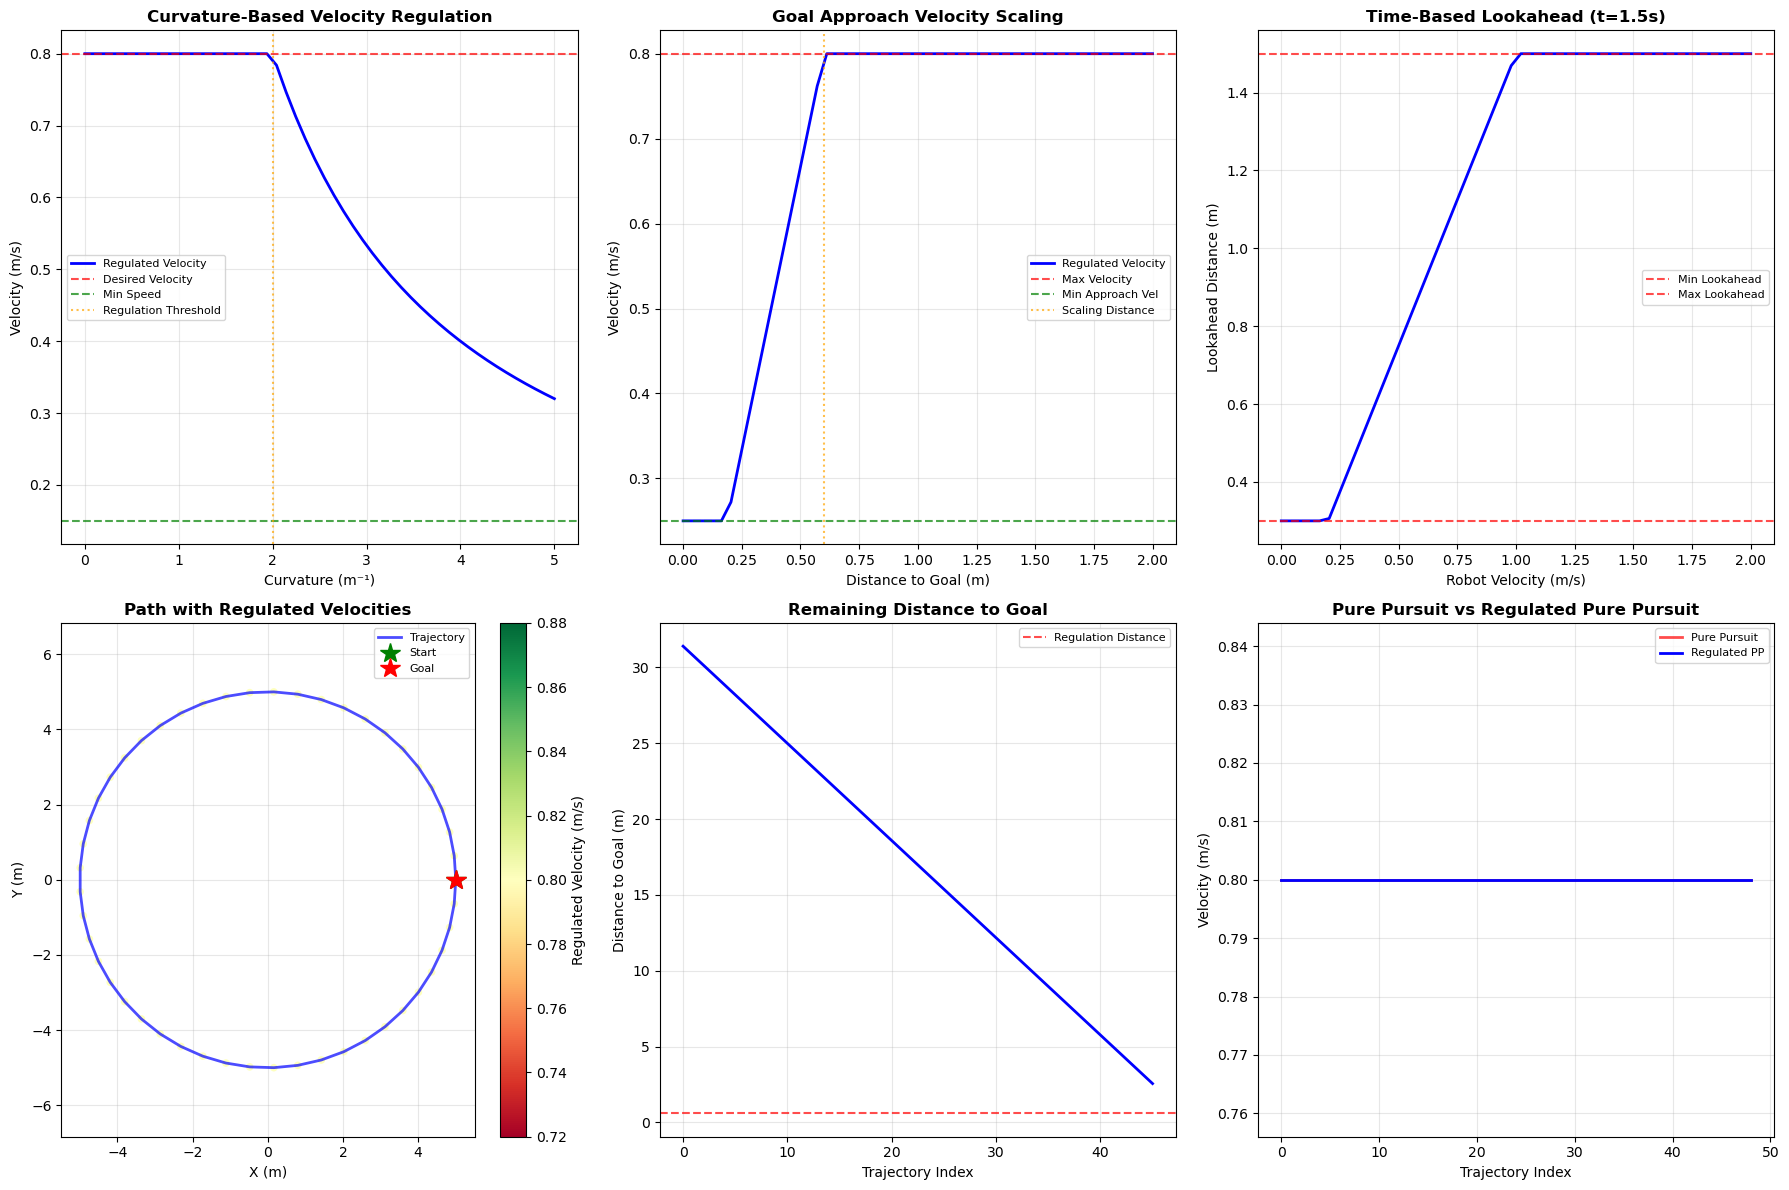

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Velocity Regulation - Curvature Effect
ax = axes[0, 0]

curvatures = np.linspace(0, 5, 50)
v_desired = 0.8
regulated_vels = []

for curv in curvatures:
    v_reg = regulate_velocity_curvature(v_desired, curv, True,
                                        min_radius_for_regulation, min_regulated_speed)
    regulated_vels.append(v_reg)

ax.plot(curvatures, regulated_vels, 'b-', linewidth=2, label='Regulated Velocity')
ax.axhline(y=v_desired, color='r', linestyle='--', label='Desired Velocity', alpha=0.7)
ax.axhline(y=min_regulated_speed, color='g', linestyle='--', label='Min Speed', alpha=0.7)
ax.axvline(x=1/min_radius_for_regulation, color='orange', linestyle=':', 
           label='Regulation Threshold', alpha=0.7)
ax.set_xlabel('Curvature (m⁻¹)', fontsize=10)
ax.set_ylabel('Velocity (m/s)', fontsize=10)
ax.set_title('Curvature-Based Velocity Regulation', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Velocity Regulation - Goal Approach
ax = axes[0, 1]

distances = np.linspace(0, 2.0, 50)
approach_vels = []

for dist in distances:
    v_reg = regulate_velocity_goal_approach(v_desired, dist, desired_linear_vel,
                                             min_approach_vel, approach_vel_scaling_dist)
    approach_vels.append(v_reg)

ax.plot(distances, approach_vels, 'b-', linewidth=2, label='Regulated Velocity')
ax.axhline(y=desired_linear_vel, color='r', linestyle='--', label='Max Velocity', alpha=0.7)
ax.axhline(y=min_approach_vel, color='g', linestyle='--', label='Min Approach Vel', alpha=0.7)
ax.axvline(x=approach_vel_scaling_dist, color='orange', linestyle=':', 
           label='Scaling Distance', alpha=0.7)
ax.set_xlabel('Distance to Goal (m)', fontsize=10)
ax.set_ylabel('Velocity (m/s)', fontsize=10)
ax.set_title('Goal Approach Velocity Scaling', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Adaptive Lookahead
ax = axes[0, 2]

velocities = np.linspace(0, 2.0, 50)
lookaheads = []

for v in velocities:
    L = compute_adaptive_lookahead_distance(v, lookahead_time, min_lookahead, max_lookahead)
    lookaheads.append(L)

ax.plot(velocities, lookaheads, 'b-', linewidth=2)
ax.axhline(y=min_lookahead, color='r', linestyle='--', label='Min Lookahead', alpha=0.7)
ax.axhline(y=max_lookahead, color='r', linestyle='--', label='Max Lookahead', alpha=0.7)
ax.set_xlabel('Robot Velocity (m/s)', fontsize=10)
ax.set_ylabel('Lookahead Distance (m)', fontsize=10)
ax.set_title(f'Time-Based Lookahead (t={lookahead_time}s)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Path with Regulated Velocities
ax = axes[1, 0]

ax.plot(test_trajectory['x'], test_trajectory['y'], 'b-', 
        linewidth=2, label='Trajectory', alpha=0.7)

# Simulate regulated velocities along path
regulated_path_vels = []
for i in range(len(test_trajectory['x'])):
    curv = test_trajectory['curvature'][i]
    v_reg = regulate_velocity_curvature(0.8, curv, True,
                                        min_radius_for_regulation, min_regulated_speed)
    regulated_path_vels.append(v_reg)

scatter = ax.scatter(test_trajectory['x'], test_trajectory['y'], 
                     c=regulated_path_vels, cmap='RdYlGn', s=30, edgecolors='none')
ax.plot(test_trajectory['x'][0], test_trajectory['y'][0], 'g*', markersize=15, label='Start')
ax.plot(test_trajectory['x'][-1], test_trajectory['y'][-1], 'r*', markersize=15, label='Goal')

ax.set_xlabel('X (m)', fontsize=10)
ax.set_ylabel('Y (m)', fontsize=10)
ax.set_title('Path with Regulated Velocities', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.colorbar(scatter, ax=ax, label='Regulated Velocity (m/s)')

# Plot 5: Distance to Goal Along Path
ax = axes[1, 1]

distances_to_goal = []
indices = range(0, len(test_trajectory['x']), 5)

for idx in indices:
    pose = (test_trajectory['x'][idx], test_trajectory['y'][idx], 0)
    dist = compute_distance_to_goal(pose, test_trajectory, idx)
    distances_to_goal.append(dist)

ax.plot(list(indices), distances_to_goal, 'b-', linewidth=2)
ax.axhline(y=approach_vel_scaling_dist, color='r', linestyle='--', 
           label='Regulation Distance', alpha=0.7)
ax.set_xlabel('Trajectory Index', fontsize=10)
ax.set_ylabel('Distance to Goal (m)', fontsize=10)
ax.set_title('Remaining Distance to Goal', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Comparison - Pure Pursuit vs Regulated
ax = axes[1, 2]

# Simulate velocity commands along path
indices_comp = range(0, len(test_trajectory['x']), 2)
pp_vels = []
rpp_vels = []

for idx in indices_comp:
    curv = test_trajectory['curvature'][idx]
    pose = (test_trajectory['x'][idx], test_trajectory['y'][idx], 0)
    dist_to_goal = compute_distance_to_goal(pose, test_trajectory, idx)
    
    # Pure Pursuit (no regulation)
    v_pp = 0.8
    pp_vels.append(v_pp)
    
    # Regulated Pure Pursuit
    v_rpp = regulate_velocity_curvature(0.8, curv, True,
                                        min_radius_for_regulation, min_regulated_speed)
    v_rpp = regulate_velocity_goal_approach(v_rpp, dist_to_goal, desired_linear_vel,
                                             min_approach_vel, approach_vel_scaling_dist)
    rpp_vels.append(v_rpp)

ax.plot(list(indices_comp), pp_vels, 'r-', linewidth=2, label='Pure Pursuit', alpha=0.7)
ax.plot(list(indices_comp), rpp_vels, 'b-', linewidth=2, label='Regulated PP')
ax.set_xlabel('Trajectory Index', fontsize=10)
ax.set_ylabel('Velocity (m/s)', fontsize=10)
ax.set_title('Pure Pursuit vs Regulated Pure Pursuit', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regulated_pure_pursuit_test_results.png', dpi=150, bbox_inches='tight')
print("✓ Visualization complete")
print("✓ Saved as: regulated_pure_pursuit_test_results.png\n")
plt.show()
